* Yapay zeka kullanılarak herhangi bir motorlu taşıtın yakıt tüketimi tahmini yapılarak, gerekli müdahaleler ve yöntemler ile yakıt tüketimi azaltılabilir.

## Veri Seti 

* Veri içerisinde, arabaların teknik özellikleri bulunmaktadır.
* Veri içerisinde bulunan özelliklerin tanımları:
    1. hedef: Yakıt tüketimi, 1 galon benzin/mazotla kaç mil gittiğini gösterir.
    2. silindir: Motorun güç birimi
    3. motor_hacmi: Aracın motor hacmi
    4. beygir_gücü: Aracın beygir gücü
    5. agirlik: Aracın ağırlığı
    6. ivme: Aracın hızlanması
    7. model_yil: Aracın yılı
    8. mensei: Aracın hangi ülkenin ürünü olduğu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import clone

import warnings
warnings.filterwarnings("ignore")

In [3]:
sutun_isim = ["hedef", "silindir", "motor_hacmi", "beygir_gucu", "agirlik", "ivme", "model_yil", "mensei"]
veri = pd.read_csv("auto-mpg.csv", na_values="?")
# na_values parametresi ile "?" karakterinin eksik veri olarak kabul edilmesini sağlayabilirsiniz.

In [4]:
veri.rename(columns={"mpg" : "hedef",
                     "cylinders" : "silindir",
                     "displacement" : "motor_hacmi",
                     "horsepower" : "beygir_gucu",
                     "weight" : "agirlik",
                     "acceleration" : "ivme",
                     "model year" : "model_yil",
                     "origin" : "mensei",
                     "car name" : "arac_isim"}, inplace=True)

In [5]:
veri.drop(["arac_isim"], axis=1, inplace=True)

In [6]:
veri.head()

,hedef,silindir,motor_hacmi,beygir_gucu,agirlik,ivme,model_yil,mensei
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1


In [7]:
veri.shape

(398, 8)

In [8]:
veri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hedef        398 non-null    float64
 1   silindir     398 non-null    int64  
 2   motor_hacmi  398 non-null    float64
 3   beygir_gucu  392 non-null    float64
 4   agirlik      398 non-null    int64  
 5   ivme         398 non-null    float64
 6   model_yil    398 non-null    int64  
 7   mensei       398 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 25.0 KB


In [9]:
veri.describe()

,hedef,silindir,motor_hacmi,beygir_gucu,agirlik,ivme,model_yil,mensei
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [10]:
veri.isna().sum()

hedef          0
silindir       0
motor_hacmi    0
beygir_gucu    6
agirlik        0
ivme           0
model_yil      0
mensei         0
dtype: int64

## Keşifsel Veri Analizi

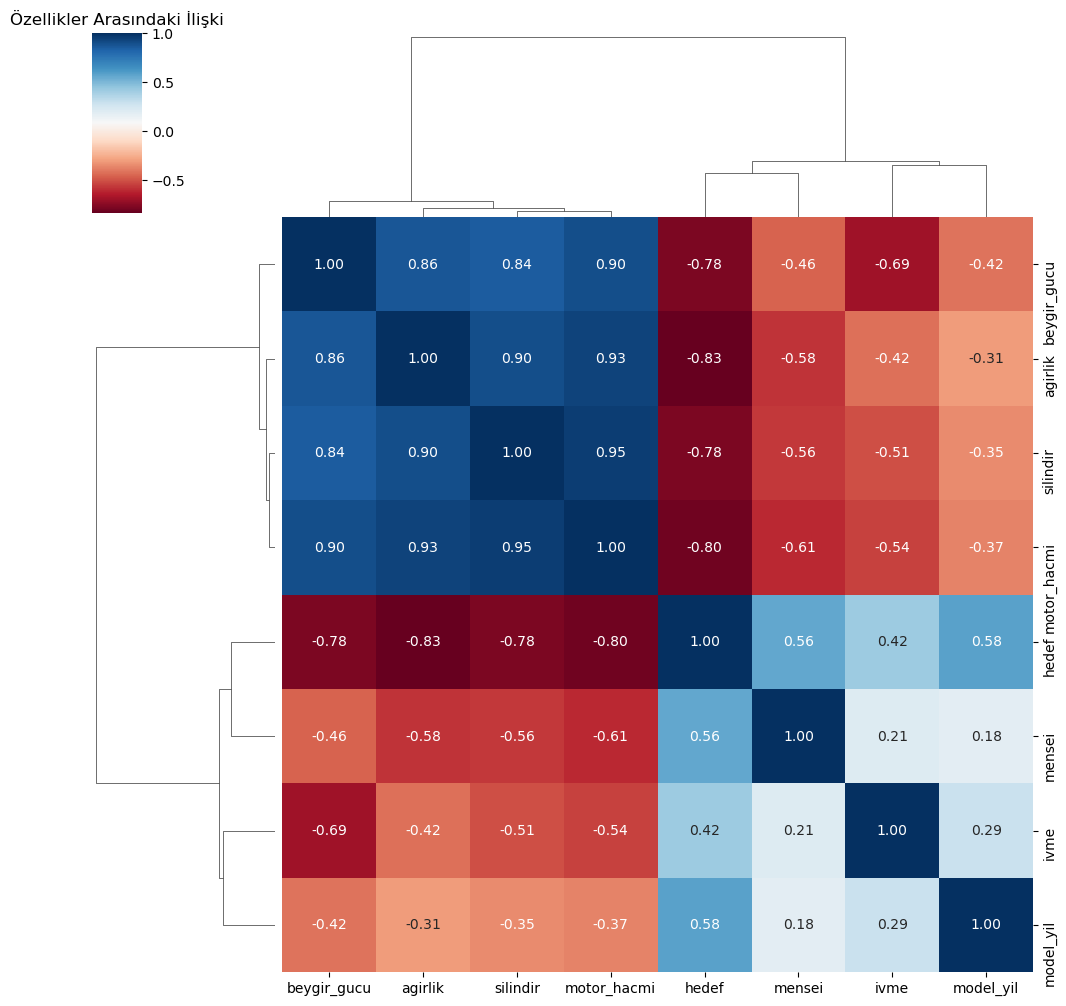

In [11]:
corr = veri.corr()
sns.clustermap(corr, annot=True, fmt=".2f", cmap="RdBu")
plt.title("Özellikler Arasındaki İlişki")
plt.show()

* Hedef ile mensei, model yılı arasında korelasyon vardır.

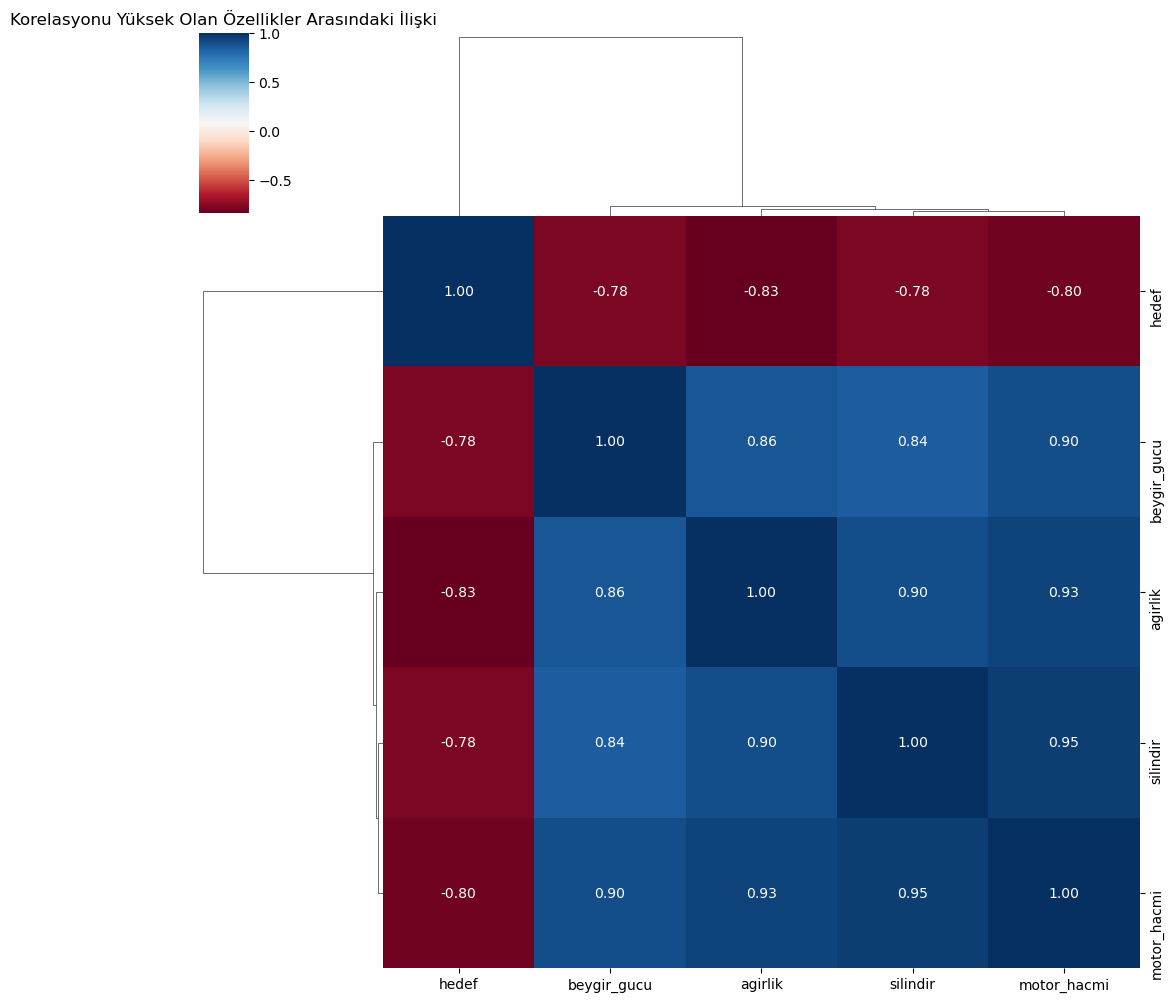

In [12]:
esik = 0.75
filtre = np.abs(corr["hedef"]) > esik
corr_ = corr.columns[filtre].tolist()
sns.clustermap(veri[corr_].corr(), annot = True, fmt=".2f", cmap="RdBu")
plt.title("Korelasyonu Yüksek Olan Özellikler Arasındaki İlişki")
plt.show()

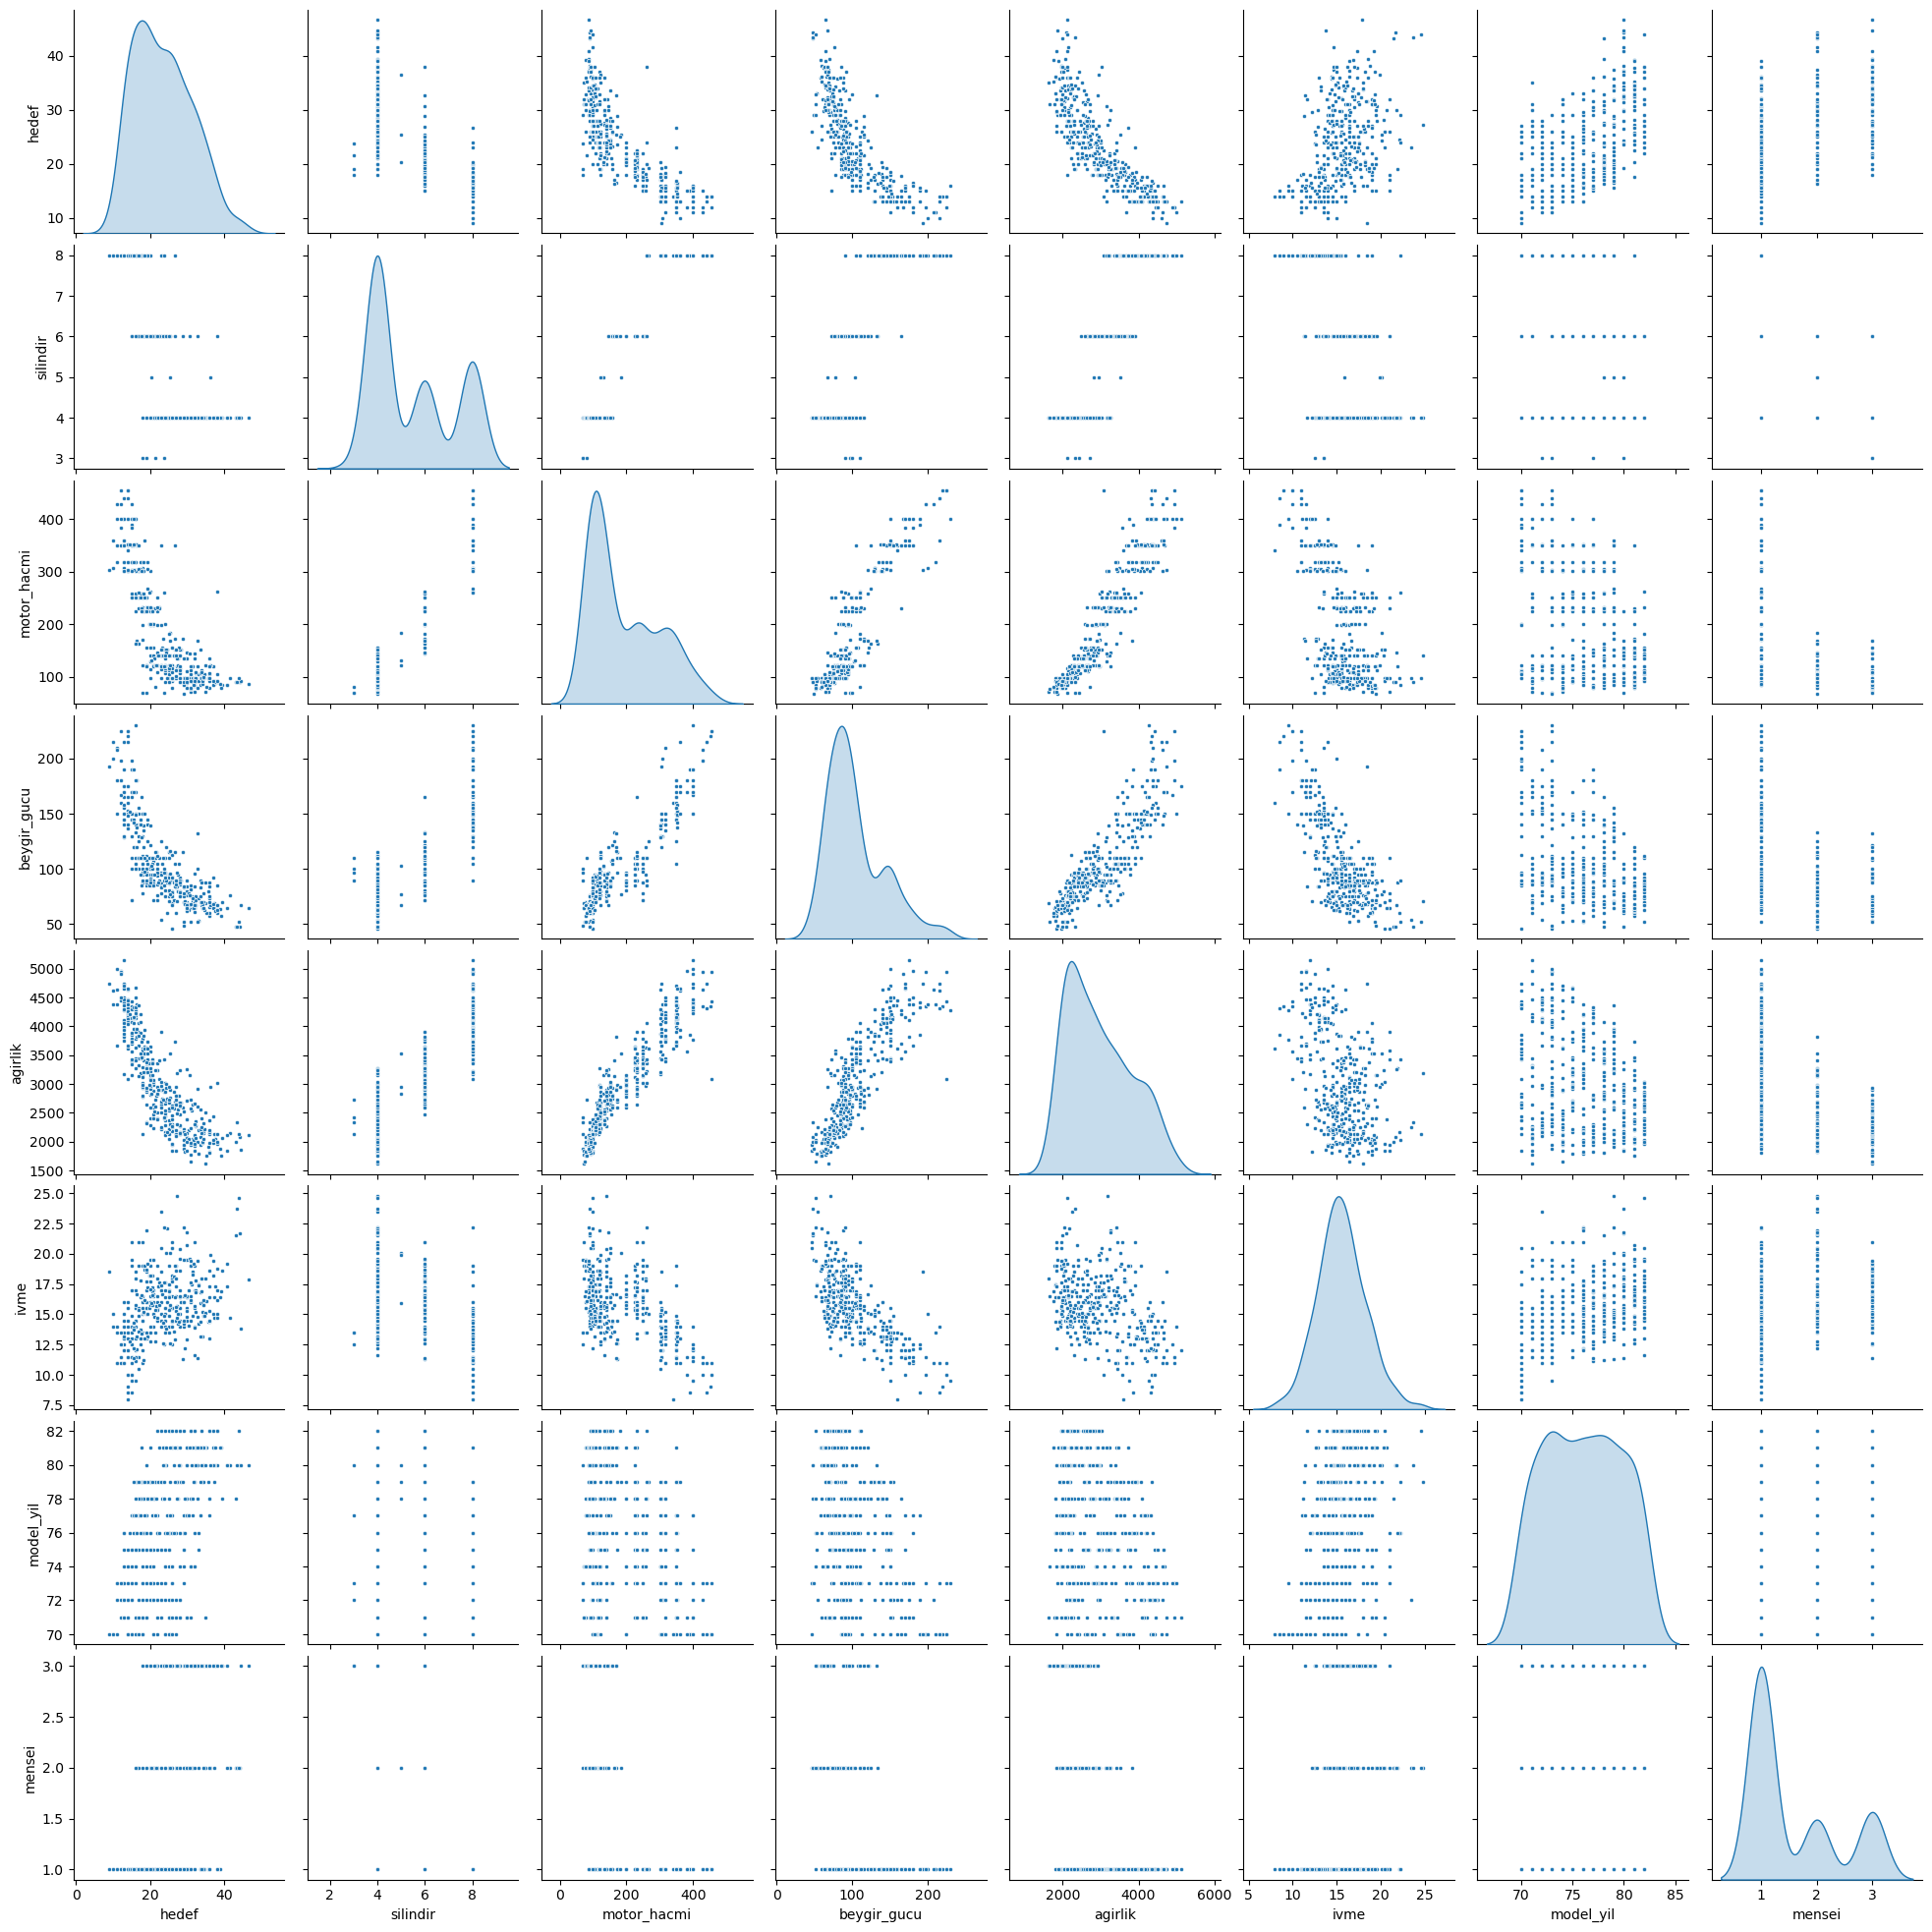

In [13]:
sns.pairplot(veri, diag_kind="kde", markers=".")
plt.show()

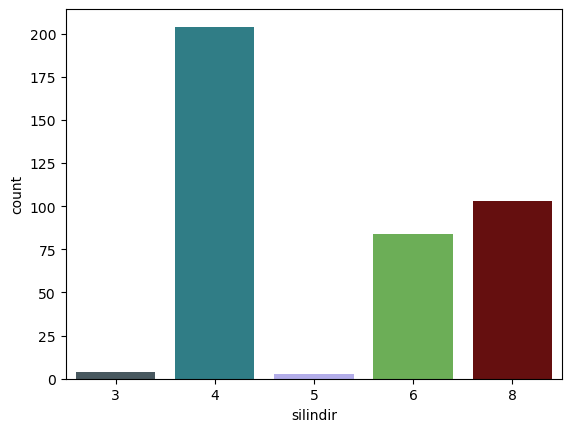

4    204
8    103
6     84
3      4
5      3
Name: silindir, dtype: int64


In [14]:
plt.figure()
sns.countplot(x = veri["silindir"], palette=["#445963", "#228894", "#aba3f3", "#65bc49", "#730101"])
plt.show()
print(veri["silindir"].value_counts())

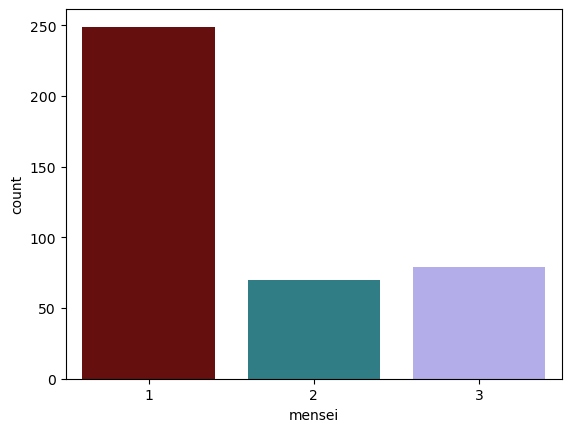

1    249
3     79
2     70
Name: mensei, dtype: int64


In [15]:
plt.figure()
sns.countplot(x = veri["mensei"], palette=["#730101", "#228894", "#aba3f3"])
plt.show()
print(veri["mensei"].value_counts())

* 5 farklı silindir değeri ve 3 farklı mensei değeri bulunmaktadır.

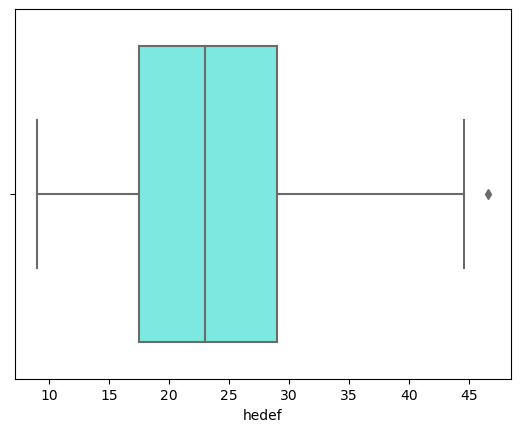

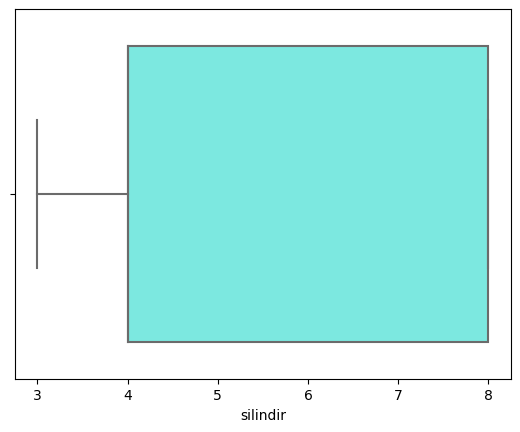

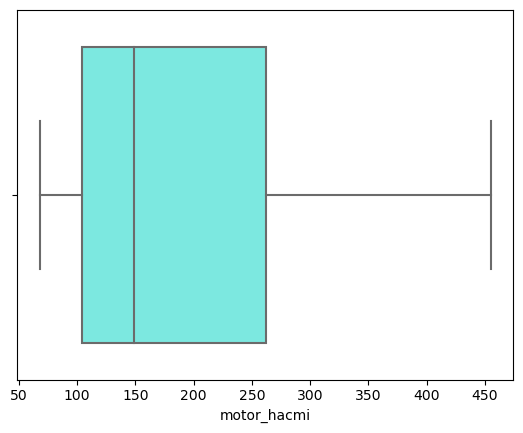

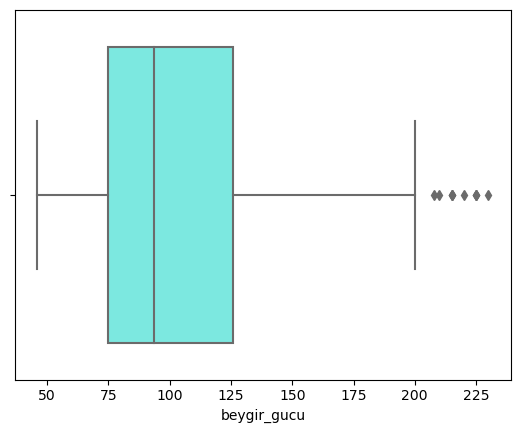

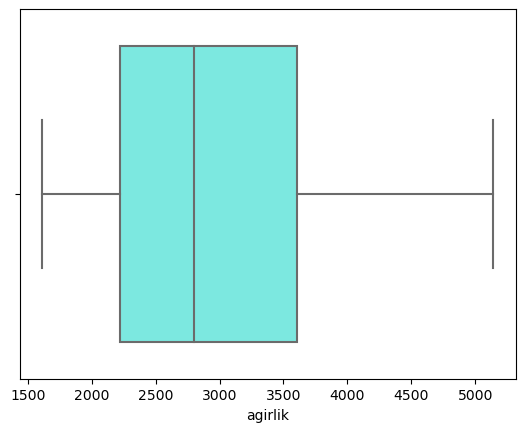

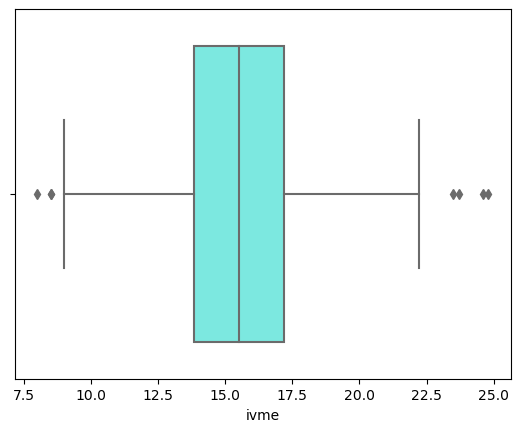

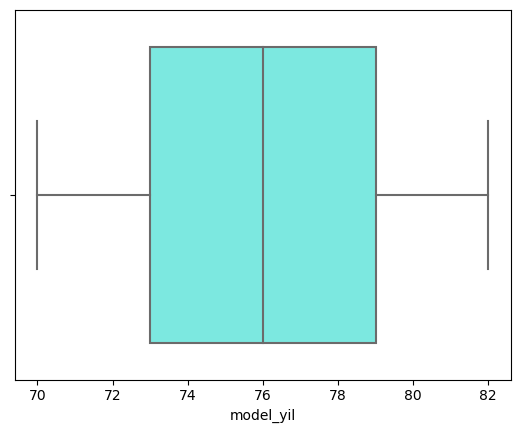

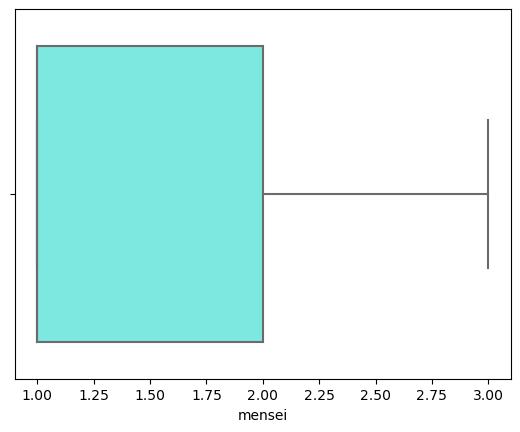

In [19]:
for c in veri.columns:
    plt.figure()
    sns.boxplot(x=c, data=veri, orient="v", color="#6afaef")

* Beygir gücü ve ivme özelliklerinde aykırı değerler vardır.

## Aykırı Değerlerin Çıkarılması

In [21]:
tanım = veri.describe()
tanım

,hedef,silindir,motor_hacmi,beygir_gucu,agirlik,ivme,model_yil,mensei
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [22]:
# beygir gücü
thr = 2 # Aykırı değerleri belirlemek için kullanılacak olan eşik değerini belirler. 
# Bu değer, veri setindeki aykırı değerlerin ne kadar uzaklıkta kabul edileceğini kontrol eder.

horsepower_desc = tanım["beygir_gucu"] # "beygir_gucu" sütununun istatistiksel tanımını alır. 
# Bu tanım, kutu grafiği hesaplamalarında kullanılacak olan değerleri içerir.

q3_hp = horsepower_desc[6] # "beygir_gucu" sütununun 3. çeyreğini (üst çeyrek) temsil eden değeri alır.
q1_hp = horsepower_desc[4] # "beygir_gucu" sütununun 1. çeyreğini (alt çeyrek) temsil eden değeri alır.
IQR_hp = q3_hp - q1_hp # Interquartile Range (IQR) değerini hesaplar. IQR, çeyrekler arası mesafeyi temsil eder.

top_limit_hp = q3_hp + thr*IQR_hp # Üst sınırı belirler. Bu sınır, üst çeyreğe eklenen bir eşik değeri ile IQR'nin çarpımıdır.
bottom_limit_hp = q1_hp - thr*IQR_hp # Alt sınırı belirler. Bu sınır, alt çeyrekten çıkarılan bir eşik değeri ile IQR'nin çarpımıdır.

filter_hp_bottom = bottom_limit_hp < veri["beygir_gucu"] # Aykırı değerlerin alt sınırından büyük olan değerleri filtrelemek için bir filtre oluşturur.
filter_hp_top = veri["beygir_gucu"] < top_limit_hp # Aykırı değerlerin üst sınırından küçük olan değerleri filtrelemek için bir filtre oluşturur.
filter_hp = filter_hp_bottom & filter_hp_top # Alt ve üst sınırlar arasında kalan değerleri filtrelemek için iki filtre arasında bir mantıksal "ve" işlemi gerçekleştirir.

veri = veri[filter_hp] # Filtrelenen aykırı değerlerin üzerinde uygulanarak, veri setinde sadece alt ve üst sınırlar arasında kalan değerleri tutar.

In [23]:
# ivme
acceleration_desc = tanım["ivme"] 

q3_acc = acceleration_desc[6] 
q1_acc = acceleration_desc[4] 
IQR_acc = q3_acc - q1_acc

top_limit_acc = q3_acc + thr*IQR_acc
bottom_limit_acc = q1_acc - thr*IQR_acc 

filter_acc_bottom = bottom_limit_acc < veri["ivme"] 
filter_acc_top = veri["ivme"] < top_limit_acc 
filter_acc = filter_acc_bottom & filter_acc_top 

veri = veri[filter_acc] 

## Öz Nitelik Mühendisliği - Çarpıklık Problemi

* Çarpıklık olasılık kuramı ve istatistik bilim dallarında bir reel-değerli değişkenin olasılık dağılımının simetrik olmayışının ölçülmesidir.
* Box Cox dönüşümü ile problemin olumsuz etkisini azaltacağım.
* Box Cox dönüşümü, normal olmayan bağımlı değişkenlerin normal bir şekle dönüştürülmesidir. Normallik, birçok istatistiksel teknik için önemli bir varsayımdır.

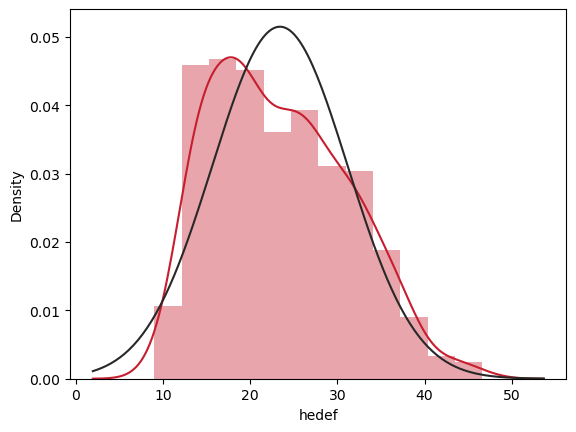

In [26]:
# hedef değişkenin dağılımı
plt.figure()
sns.distplot(veri["hedef"], fit = norm, color="#c61e2f")
plt.show()

In [27]:
# verinin mu ve sigma değerlerini bulalım
(mu, sigma) = norm.fit(veri["hedef"])
print("mu: ", mu)
print("sigma: ", sigma)

mu:  23.402570694087405
sigma:  7.743685947581485


#### Q - Q Grafiği

* İstatistiklerde, iki olasılık dağılımının miktarlarını birbirlerine göre çizerek karşılaştırmak için grafiksel bir yöntem olan bir olasılık grafiğidir.

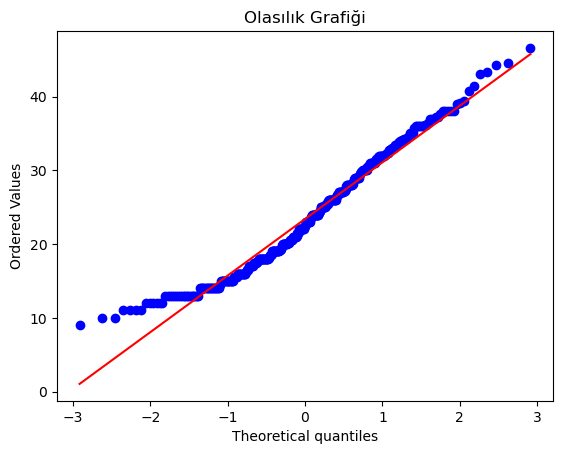

In [32]:
plt.figure()
stats.probplot(veri["hedef"], plot=plt)
plt.title("Olasılık Grafiği")
plt.show()

In [33]:
# log1p dönüşümü ile çarpıklığı azaltalım
veri["hedef"] = np.log1p(veri["hedef"])

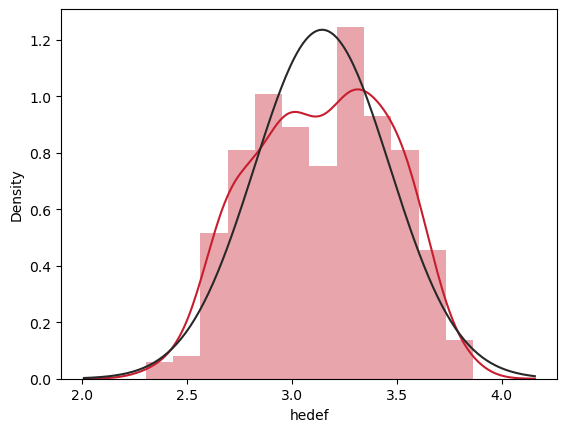

In [34]:
plt.figure()
sns.distplot(veri["hedef"], fit = norm, color="#c61e2f")
plt.show()

* Hedef değişkeninde bulunan çarpıklık düzelerek, hedef değişkenin dağılımı normal dağılıma yaklaştı.

In [35]:
# çarpıklığı düzeltilen hedef değişkenin mu ve sigma değerleri
(mu, sigma) = norm.fit(veri["hedef"])
print("mu: ", mu)
print("sigma: ", sigma)

mu:  3.1435025569661876
sigma:  0.32306031944366265


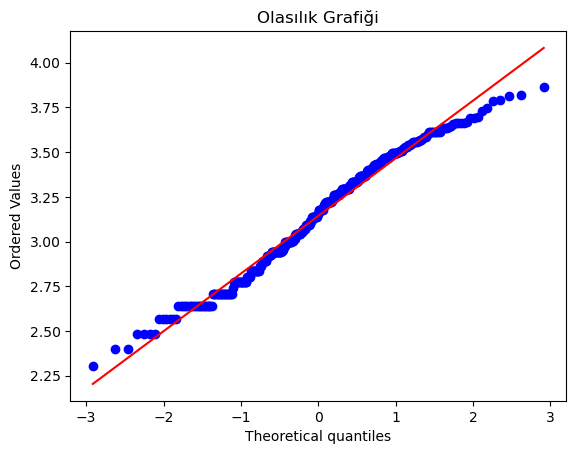

In [36]:
plt.figure()
stats.probplot(veri["hedef"], plot=plt)
plt.title("Olasılık Grafiği")
plt.show()

In [39]:
# diğer değişkenlerin çarpıklıklarını kontrol edelim
carpiklik = veri.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
carpiklik = pd.DataFrame(carpiklik, columns=["çarpık"])
carpiklik

,çarpık
beygir_gucu,1.059725
mensei,0.914689
motor_hacmi,0.696615
agirlik,0.521721
silindir,0.504455
ivme,0.179487
model_yil,0.021198
hedef,-0.113017


* Genelde, çarpıklık -1'den küçük veya 1'den büyükse, dağılım oldukça çarpıktır.
* Çarpıklık -1 ile -0.5 arasında veya 0.5 ile 1 arasında ise dağılım orta derecede çarpıktır.
* Çarpıklık -0.5 ile 0.5 arasındaysa dağılım yaklaşık olarak simetriktir.

* Bizim veri setimizde beygir gücü oldukça çarpık, mensei orta derece çarpık olarak adlandırılabilir.

## Öz Nitelik Mühendisliği - Kodlama

* Veri içerisinde bulunan silindir ve mensei özelliklerini kategorik hale getireceğim.

In [42]:
veri["silindir"] = veri["silindir"].astype(str)
veri["mensei"] = veri["mensei"].astype(str)

In [43]:
veri = pd.get_dummies(veri)

In [46]:
veri.head(2)

,hedef,motor_hacmi,beygir_gucu,agirlik,ivme,model_yil,silindir_3,silindir_4,silindir_5,silindir_6,silindir_8,mensei_1,mensei_2,mensei_3
0,2.944439,307.0,130.0,3504,12.0,70,0,0,0,0,1,1,0,0
1,2.772589,350.0,165.0,3693,11.5,70,0,0,0,0,1,1,0,0


### Ön İşlem

In [47]:
x = veri.drop(["hedef"], axis=1)
y = veri["hedef"]

In [48]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.9, random_state=0)

In [49]:
# Standardizasyon
sc = RobustScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Doğrusal Regresyon

In [50]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print("Doğrusal regresyon katsayıları: ", lr.coef_)

Doğrusal regresyon katsayıları:  [ 0.17239458 -0.04295512 -0.46451729 -0.02090801  0.15931859 -0.21558218
  0.03454079  0.47219674 -0.14847697 -0.14267838 -0.00982214 -0.0289227
  0.03874484]


In [51]:
tahmin = lr.predict(X_test)
mse_dogrusal = mean_squared_error(y_test, tahmin)
print("Doğrusal regresyon ortalama kare hatası: ", mse_dogrusal)

Doğrusal regresyon ortalama kare hatası:  0.017664424218531385


### Ridge Regresyon

* Ridge regresyon, sapmalı tahmin yöntemlerinden biridir.
* Çoklu doğrusal bağlılık olduğunda en küçük kareler tahmincilerin varyanslarından daha küçük varyanslı tahminler verdiğinden tercih edilebilir.
* Kullanılması ile tüm değişkenlere modelde yer verme imkanı olabilmektedir.

In [55]:
ridge = Ridge(random_state=42, max_iter=10000)
# max_iter parametresi, optimize edici algoritmanın maksimum iterasyon sayısını belirtir.

alphas = np.logspace(-4,-0.5,30) # alphas adında bir dizi oluşturuyoruz. 
# Bu dizi, Ridge regresyon modelinde kullanılacak alpha hiperparametresinin farklı değerlerini içerir. 

tuned_parameters = [{"alpha" : alphas}] # GridSearchCV'ye geçirilecek hiperparametre değerlerini içeren bir sözlük listesi oluşturuyoruz. 
# Burada sadece alpha değerleri ayarlanacak.

n_folds = 5 # Cross-validation için kat sayısını belirliyoruz. Veri kümesi 5 katlamalı çapraz doğrulama için kullanılacak.

clf = GridSearchCV(ridge, tuned_parameters, cv=n_folds, scoring="neg_mean_squared_error")
clf.fit(X_train, y_train)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

print("Ridge katsayıları: ", clf.best_estimator_.coef_) 
# En iyi tahminleyiciyi temsil eden clf.best_estimator_ üzerinden Ridge regresyon modelinin katsayılarını yazdırıyoruz.

ridge = clf.best_estimator_
print("Ridge en iyi tahminleyici: ", ridge)

tahmin = clf.predict(X_test)
mse_ridge = mean_squared_error(y_test, tahmin)
print("Ridge ortalama kare hatası: ", mse_ridge)

Ridge katsayıları:  [ 0.03556731 -0.06767124 -0.3267071  -0.02547885  0.16932575 -0.17319901
  0.04352577  0.30948827 -0.10955053 -0.0702645  -0.01096284 -0.01898102
  0.02994387]
Ridge en iyi tahminleyici:  Ridge(alpha=0.31622776601683794, max_iter=10000, random_state=42)
Ridge ortalama kare hatası:  0.014480849742605585


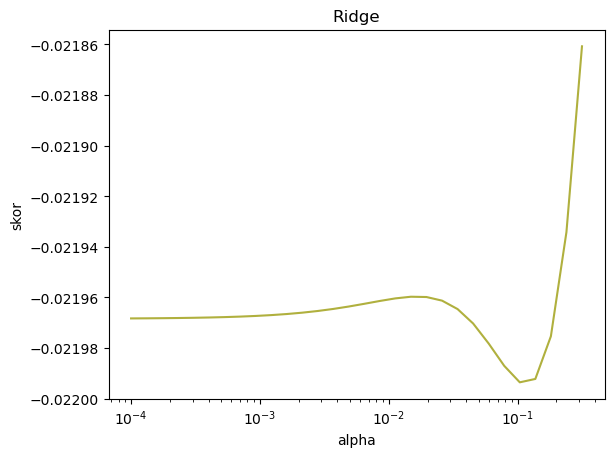

In [57]:
plt.figure()
plt.semilogx(alphas, scores, color = "#b0b03e")
# semilogx fonksiyonunu kullanarak alpha değerlerini x ekseni ve skorları y ekseni olarak kullanarak bir çizgi grafiği 
# çizdiriyoruz. alphas alpha değerlerini, scores ise GridSearchCV sonuçlarındaki skorları temsil eder.
plt.xlabel("alpha")
plt.ylabel("skor")
plt.title("Ridge")
plt.show()

### Lasso Regresyon

* Makine öğreniminde, ürettiği istatistiksel modelin tahmin doğruluğunu ve yorumlanabilirliğini arttırmak için hem değişken seçimi hem de düzenlemeyi gerçekleştiren bir regresyon analiz yöntemidir.

In [58]:
lasso = Lasso(random_state=42, max_iter=10000)
alphas = np.logspace(-4,-0.5,30) 

tuned_parameters = [{"alpha" : alphas}] 
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, scoring="neg_mean_squared_error")
clf.fit(X_train, y_train)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

print("Lasso katsayıları: ", clf.best_estimator_.coef_) 
lasso = clf.best_estimator_
print("Lasso en iyi tahminleyici: ", lasso)

tahmin = clf.predict(X_test)
mse_lasso = mean_squared_error(y_test, tahmin)
print("Lasso ortalama kare hatası: ", mse_lasso)

Lasso katsayıları:  [ 0.         -0.01633672 -0.38581267 -0.01070863  0.16792525 -0.13633196
  0.05318774  0.35474444 -0.04299082  0.         -0.         -0.
  0.03044634]
Lasso en iyi tahminleyici:  Lasso(alpha=0.0021261123338996556, max_iter=10000, random_state=42)
Lasso ortalama kare hatası:  0.0150684786760076


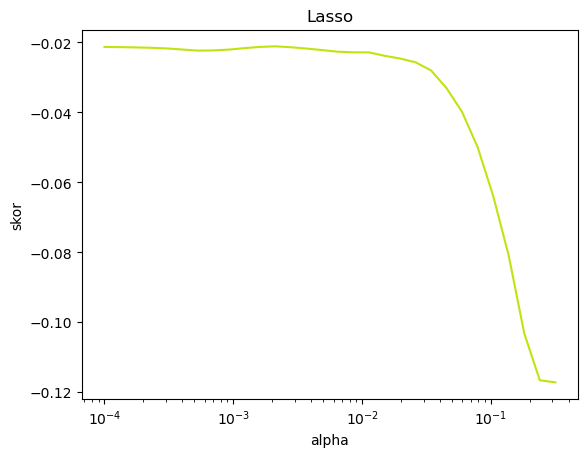

In [59]:
plt.figure()
plt.semilogx(alphas, scores, color = "#c1e310")
plt.xlabel("alpha")
plt.ylabel("skor")
plt.title("Lasso")
plt.show()

### Elastik Ağ

* Makine öğrenmesinde elastik ağ, lasso ve ridge yöntemlerinin L1 ve L2 cezalarını doğrusal olarak birleştiren düzenli bir regresyon yöntemidir.

In [60]:
parameterGrid = {"alpha" : alphas,
                 "l1_ratio" : np.arange(0.0, 1.0, 0.05)}
eNet = ElasticNet(random_state=42, max_iter=10000)
clf = GridSearchCV(eNet, parameterGrid, cv=n_folds, scoring="neg_mean_squared_error")
clf.fit(X_train, y_train)

print("Elastik Ağ Katsayıları: ", clf.best_estimator_.coef_)
print("Elastik Ağ en iyi tahminleyici: ", clf.best_estimator_)

tahmin = clf.predict(X_test)
mse_elastik = mean_squared_error(y_test, tahmin)
print("Elastik Ağ ortalama kare hatası: ", mse_elastik)

Elastik Ağ Katsayıları:  [-0.06995222 -0.09513036 -0.15692344 -0.0193438   0.15691503 -0.05437126
  0.0706516   0.08308607 -0.06119102 -0.0381754  -0.02386672 -0.00033877
  0.02420549]
Elastik Ağ en iyi tahminleyici:  ElasticNet(alpha=0.07880462815669913, l1_ratio=0.0, max_iter=10000,
           random_state=42)
Elastik Ağ ortalama kare hatası:  0.013326707315119646


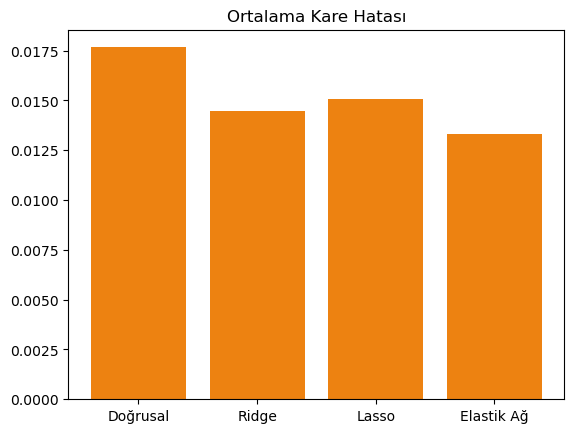

In [61]:
langs = ["Doğrusal", "Ridge", "Lasso", "Elastik Ağ"]
students = [mse_dogrusal, mse_ridge, mse_lasso, mse_elastik]
plt.bar(langs, students, color="#ed8211")
plt.title("Ortalama Kare Hatası")
plt.show()